In [ ]:
from pathlib import Path
root = Path.cwd()

import pandas as pd





import earthaccess
earthaccess.login(strategy='netrc')

import geopandas as gpd
import numpy as np
import xarray as xr
import netCDF4
import rioxarray
from rasterio.enums import Resampling
from datetime import datetime
import matplotlib.pyplot as plt
from functools import reduce
import os

from shapely.geometry import shape
from shapely.geometry import box


from pystac_client import Client

In [ ]:
catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPDAAC_ECS")
# collections = list(catalog.get_collections())
# for col in collections:
#     print(col.id)

boundary = gpd.read_file(root / 'catskills' / 'catskills_boundary.gpkg')

boundary_4326 = boundary.to_crs(epsg=4326)
bbox_utm = tuple(boundary.total_bounds)
bbox_4326 = tuple(boundary_4326.total_bounds)


query_results = catalog.search(
bbox=bbox_4326,
collections=["MSLSP30NA_011"],
datetime=f"2019-01-01/2019-12-31"
).item_collection()

In [4]:
for item in query_results:
    print(f"Item ID: {item.id}")
    for asset_key, asset in item.assets.items():
        print(f"  - {asset_key}: {asset.href}")

Item ID: SC:MSLSP30NA.011:2479575208
  - browse: https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Browse.001/2021.08.24/MSLSP_18TVM_2019.1.jpg
  - thumbnail: https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Browse.001/2021.08.24/MSLSP_18TVM_2019.1.jpg
  - 01/MSLSP_18TVM_2019: https://e4ftl01.cr.usgs.gov//DP109/COMMUNITY/MSLSP30NA.011/2019.01.01/MSLSP_18TVM_2019.nc
  - metadata: https://cmr.earthdata.nasa.gov/search/concepts/G2108839122-LPDAAC_ECS.xml
Item ID: SC:MSLSP30NA.011:2479575721
  - browse: https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Browse.001/2021.08.24/MSLSP_18TWM_2019.1.jpg
  - thumbnail: https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Browse.001/2021.08.24/MSLSP_18TWM_2019.1.jpg
  - 01/MSLSP_18TWM_2019: https://e4ftl01.cr.usgs.gov//DP109/COMMUNITY/MSLSP30NA.011/2019.01.01/MSLSP_18TWM_2019.nc
  - metadata: https://cmr.earthdata.nasa.gov/search/concepts/G2108839365-LPDAAC_ECS.xml


### Direct Earthaccess download

In [ ]:
boundary = gpd.read_file(root / 'catskills' / 'catskills_boundary.gpkg')
boundary_4326 = boundary.to_crs(epsg=4326)

results = earthaccess.search_data(
    short_name="MSLSP30NA",
    version="011",
    temporal=("2019-01-01", "2019-12-31"),
    bounding_box=bbox_4326
)

files = earthaccess.download(results,root/'LSP_data')

In [2]:
tile1 = xr.open_dataset(root / 'LSP_data' / 'MSLSP_18TVM_2019.nc')

tile2 = xr.open_dataset(root / 'LSP_data' / 'MSLSP_18TWM_2019.nc')

In [ ]:
greenup1 = tile1[['OGI','gupQA']].to_array()
greenup = tile2[['OGI','gupQA']].to_array()


# OGI: Onset Greenness Data (15% greenup)
# 50PCGI: 50% greenup
# OGMx: Onset greenness maximum (90% greenness increase)
# Peak: date of cycle peak

mosaic = greenup.combine_first(greenup1)
mosaic = mosaic.rio.write_crs(26918).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
boundary = gpd.read_file(root / 'catskills' / 'catskills_boundary.gpkg')

crop = mosaic.rio.clip(boundary.geometry)

In [26]:
gu_clipped = crop.sel(variable='OGI').clip(0,150)

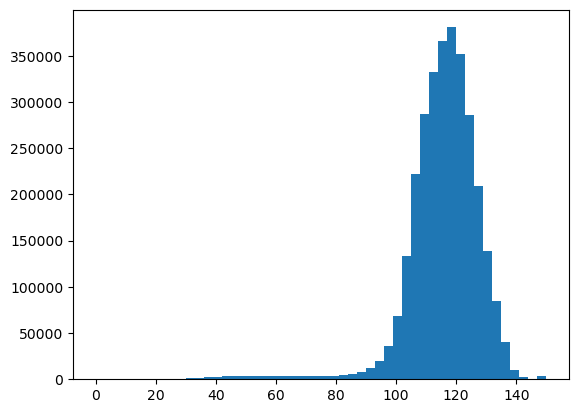

In [31]:
plt.hist(gu_clipped.values.flatten(),bins=50)
plt.show()

In [35]:
belowmean = gu_clipped.where(gu_clipped<=115)
abovemean = gu_clipped.where(gu_clipped>115)

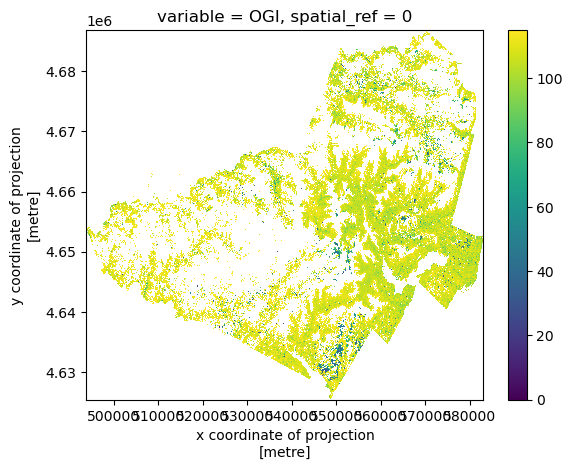

In [36]:
belowmean.plot()

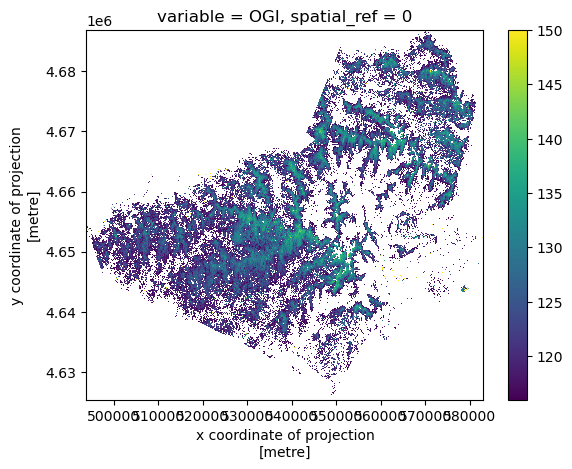

In [37]:
abovemean.plot()

In [34]:
gu_clipped.rio.to_raster(root / 'LSP_data' / 'greenup_date.tif')